In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(512)
x
y = np.sin(2*np.pi*x/32)

In [ ]:
plt.plot(x,y)
plt.show()

In [ ]:
wavlist = pywt.wavelist(kind='continuous')
wavlist

In [ ]:
coef, freqs=pywt.cwt(y,np.arange(1,129),'morl')
plt.matshow(coef)
plt.show()

In [ ]:
print(coef.shape)


# Run this cell

In [ ]:
%load_ext autoreload

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import sys, os

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
print("ROOT", ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/utils/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

import functions as f

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)


%autoreload
import wt_data
import ff_transform
import explore_fft_time_data

# Run from here

In [ ]:
COMPONENT_NAME = 'GbxHssRr'

In [52]:
def load_wt(wt_name):
    wt_instance = wt_data.load_instance(wt_name, load_minimal=False)
    down = []
    times = []
    number_of_intervals = len(wt_instance.ten_second_intervals)
    for i,interval in enumerate(wt_instance.ten_second_intervals):
        if i <= 5:
            vibration_signal = interval.sensor_df['GbxHssRr;0,0102;m/s2']
            time = interval.sensor_df['TimeStamp']
            times.append(time)
            print(interval.rotor_data)
            # down.append((vibration_signal[::100]))
            down.append(vibration_signal)
        if i > (number_of_intervals - 5):
            print("Appending the last interval")
            vibration_signal = interval.sensor_df['GbxHssRr;0,0102;m/s2']
            time = interval.sensor_df['TimeStamp']
            times.append(time)
            print(interval.rotor_data)
    del wt_instance
    del interval
    return down, times

vib_signal_wt4, times_wt4 = load_wt("WTG04")

from numpy import savez_compressed
savez_compressed('../../sensor_data/vib_signal_wt4.npz', vib_signal_wt4)
savez_compressed('../../sensor_data/times_wt4.npz', times_wt4)

del vib_signal_wt4, times_wt4


Loading WTG04...
Loaded WTG04
Appending the last interval
Appending the last interval
Appending the last interval
Appending the last interval


In [141]:
from numpy import load

# Load compressed data
vib_signal_wt4 = load('../../sensor_data/vib_signal_wt4.npz')
times_wt4 = load('../../sensor_data/times_wt4.npz')

In [142]:
vib_signal_wt4 = vib_signal_wt4['arr_0']
times_wt4 = times_wt4['arr_0']

In [146]:
print(vib_signal_wt4.shape)
print(times_wt4.shape)

(6, 262144)
(10, 262144)


In [23]:
from scipy import stats
stats.describe(vib_signal_wt4[2])

DescribeResult(nobs=262144, minmax=(1140.154670267, 1254.097433651), mean=1197.8798405171483, variance=156.36851298741024, skewness=-0.012513486195968326, kurtosis=0.03141294128650163)

5
1310720


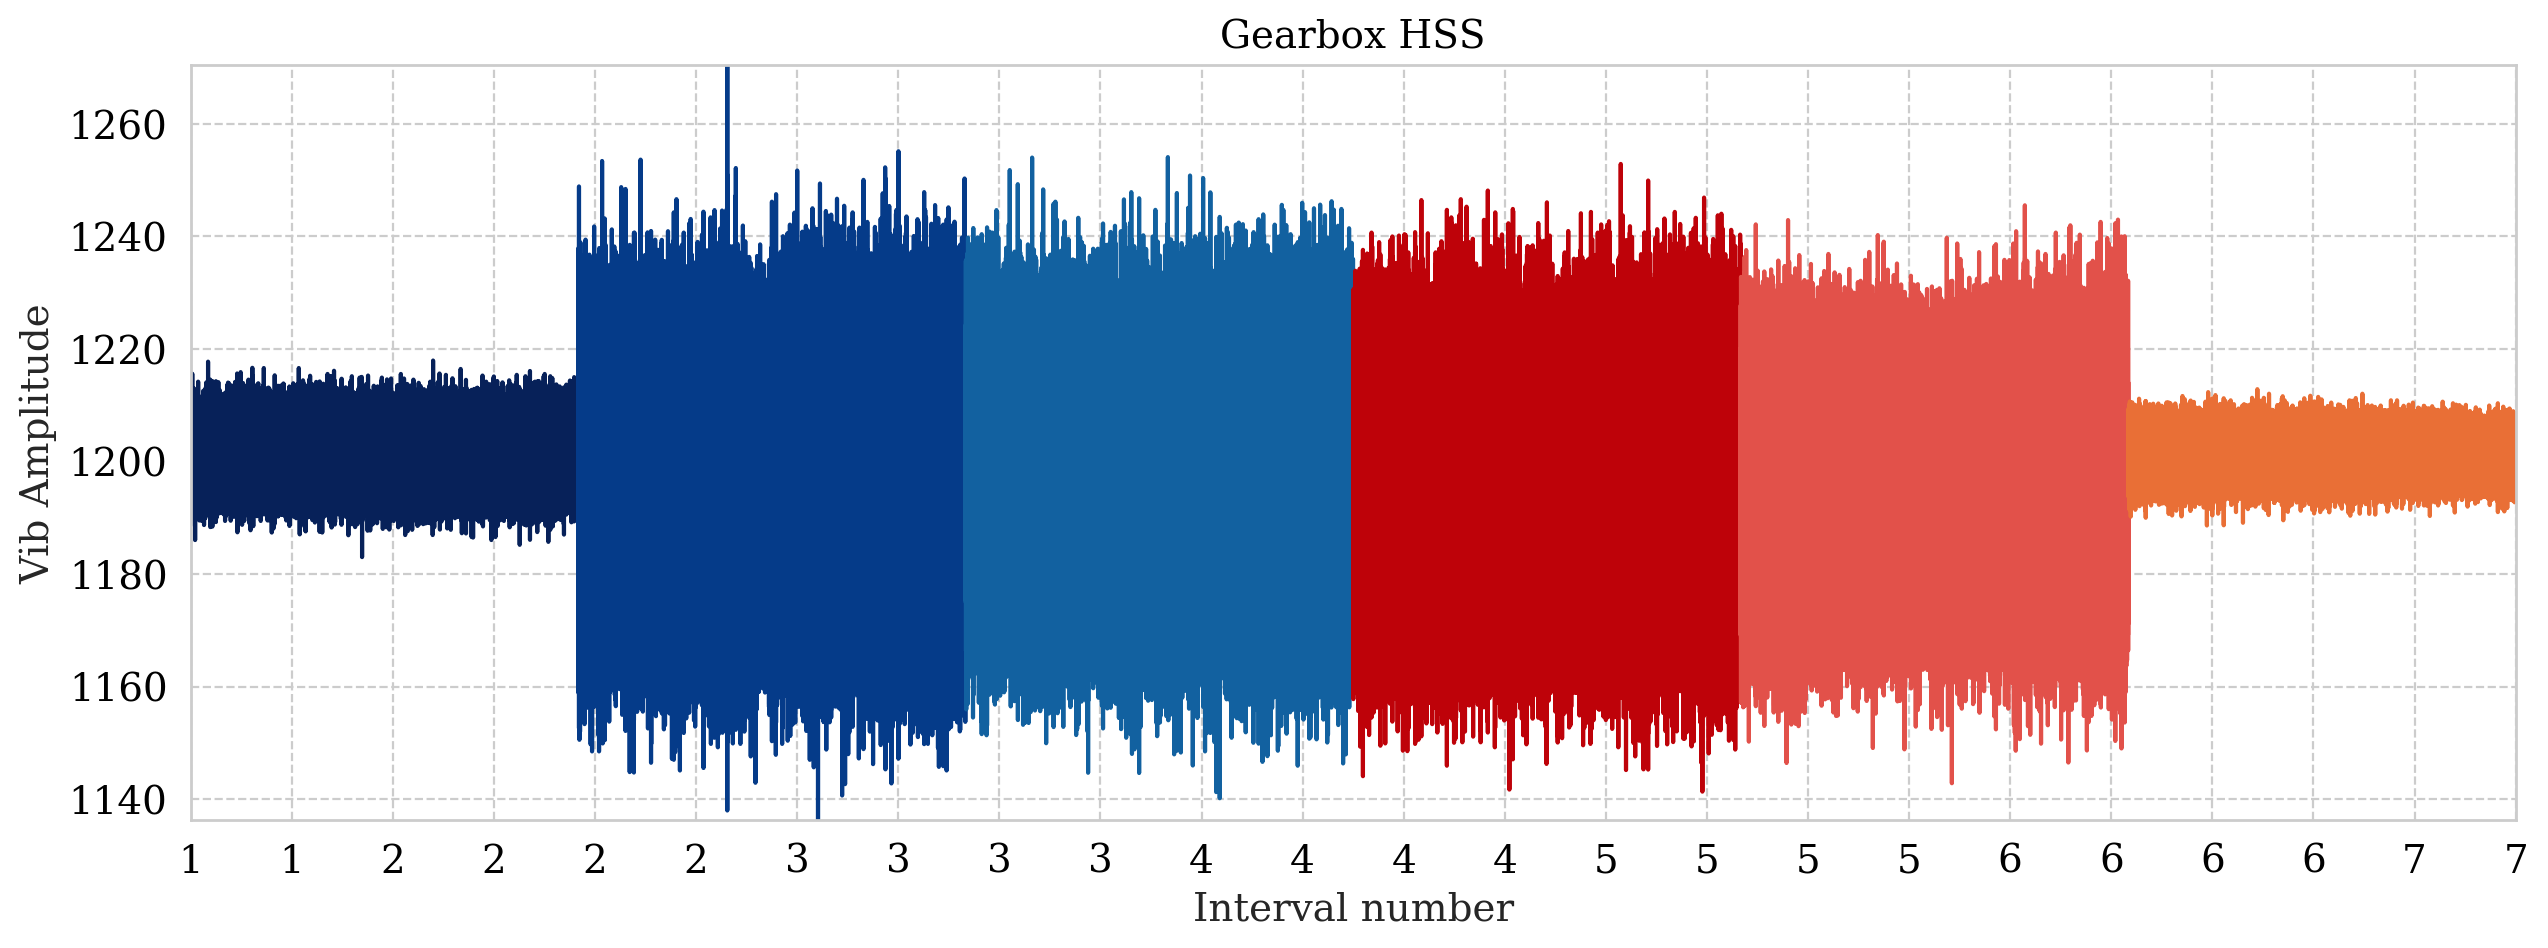

In [55]:
def plot_vib_consecutive(down):
    indexes = []
    index_start=0
    fig, ax = plt.subplots(figsize=(15,5))
    for i, d in enumerate(down):
        indexes.append(index_start)
        index_end = len(d)
        x = np.arange(index_start, index_start+index_end)
        index_start = len(x) + index_start
        plt.plot(x,d)
        plt.margins(0)
    print(len(np.linspace(0,index_start+index_end,5)))
    plt.xticks(np.linspace(0,index_start,24),[int(round(elem)) for i,elem in enumerate(np.linspace(1,len(down)+1,24))])
    #locs, labels = plt.xticks()
    #ax.set_xticks(indexes)
    #ax.set_xticklabels(np.arange(1,len(indexes)+1))
    # plt.xticks(fontsize=7, rotation=90)
    print((indexes[-1]))
    plt.title("Gearbox HSS")
    plt.xlabel("Interval number")
    plt.ylabel("Vib Amplitude")
    plt.show()
plot_vib_consecutive(vib_signal_wt4)

In [56]:
def get_sampling_freq(signal,times):
    for i in range(len(np.array(times))):
        times = np.array(times)
        T = times[0] - times[1]
        ending_time = np.array(times)[-1]
        N = len(signal)
        fs = N/ending_time
        break
    return fs, N, T, ending_time

fs, N, T, ending_time = get_sampling_freq(vib_signal_wt4[0],times_wt4[0])
fs

25600.097656622533

In [57]:
def perform_fft(amplitudes, timestamps,ax ):
    t = timestamps
    sig = amplitudes
    mean_amplitude = np.mean(sig)
    sig = sig - mean_amplitude  # Centering around 0
    fft = np.fft.fft(sig)
    N = sig.size
    T = t[1] - t[0]

    f = np.linspace(0, 1 / T, N, )  # start, stop, number of. 1 / T = frequency is the biggest freq

    f = f[:N // 2]
    y = np.abs(fft)[:N // 2]
    y_norm = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    fft_modulus_norm = y_norm
    ax.plot(f,fft_modulus_norm)

# perform_fft(sig, t)

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# fps = 2000
#sine_fq = 10 #Hz
duration = ending_time #seconds
#sine_5Hz = sine_generator(fps,sine_fq,duration)
#sine_fq = 1 #Hz
duration = ending_time #seconds
# sine_1Hz = sine_generator(fps,sine_fq,duration)

# sine = sine_5Hz + sine_1Hz
hp_cutoff = 2000
filtered_sine_wt4 = butter_highpass_filter(vib_signal_wt4[0],hp_cutoff,fs)
filtered_sine_wt4

In [59]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## lowcut = 4000, highcut = 6000

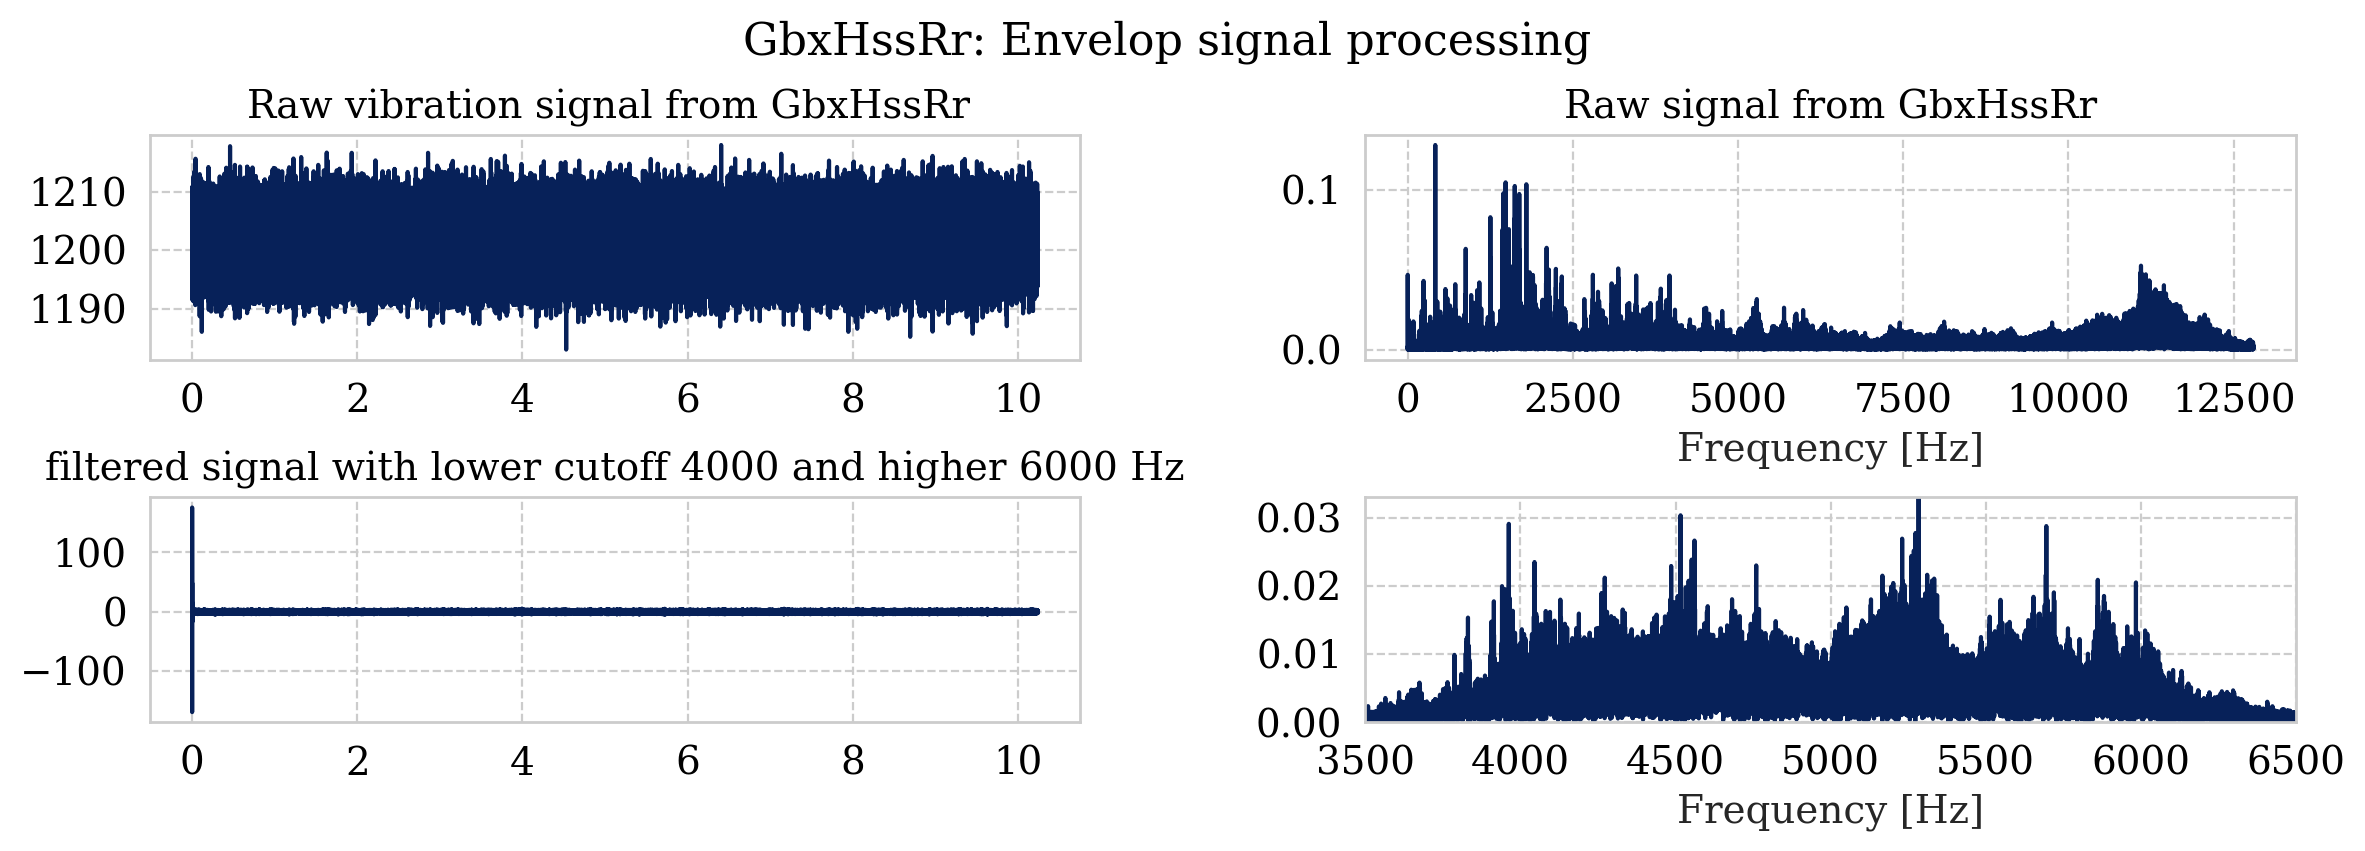

In [122]:
lowcut = 4000
highcut = 6000
fs = fs # already defined
bandpass1_filtered = butter_bandpass_filter(vib_signal_wt4[0],lowcut, highcut, fs, order=5)
bandpass1_filtered
plot_enveloping_process(2,2,COMPONENT_NAME, vib_signal_wt4[0],bandpass1_filtered,times_wt4[0],lowcut,highcut,times_wt4[0] )

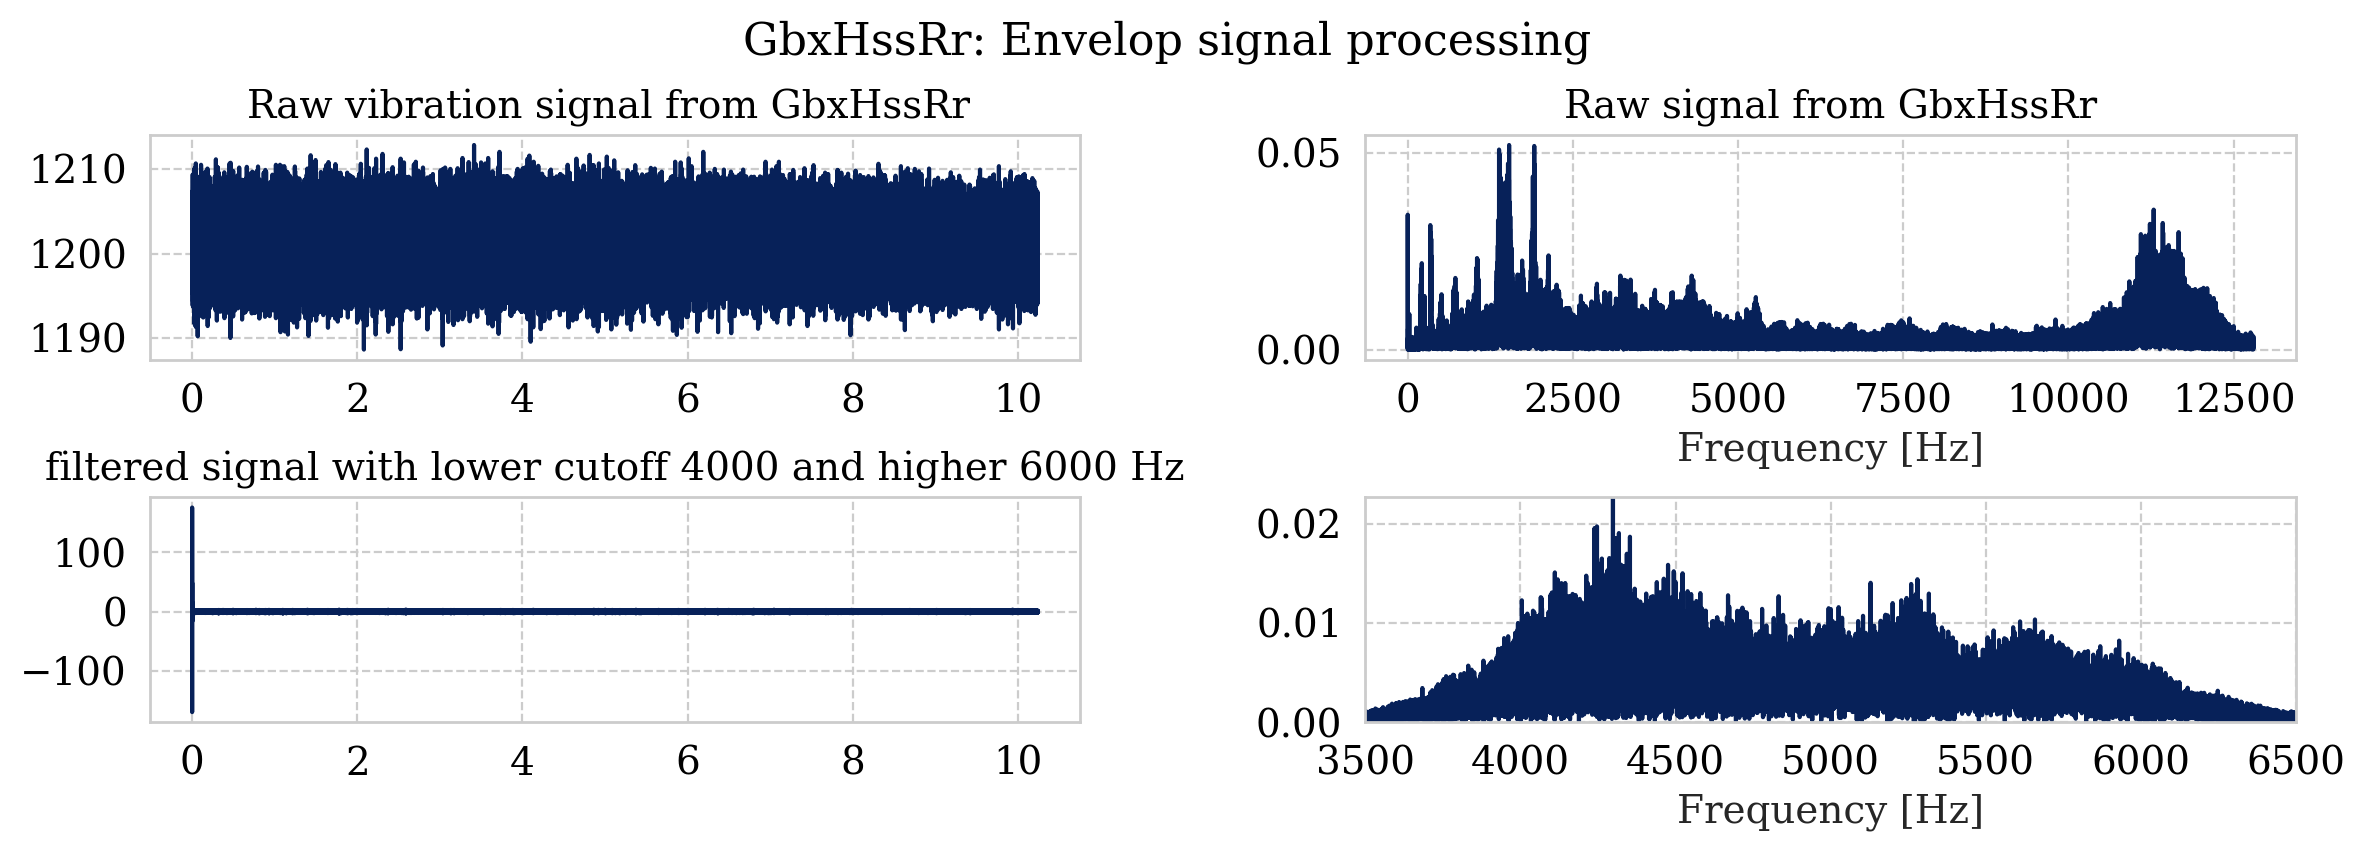

In [123]:
lowcut = 4000
highcut = 6000
fs = fs # already defined
bandpass1_filtered = butter_bandpass_filter(vib_signal_wt4[-1],lowcut, highcut, fs, order=5)
bandpass1_filtered
plot_enveloping_process(2,2,COMPONENT_NAME, vib_signal_wt4[-1],bandpass1_filtered,times_wt4[-1],lowcut,highcut,times_wt4[-1] )

## lowcut = 5000, highcut = 6000

### First interval

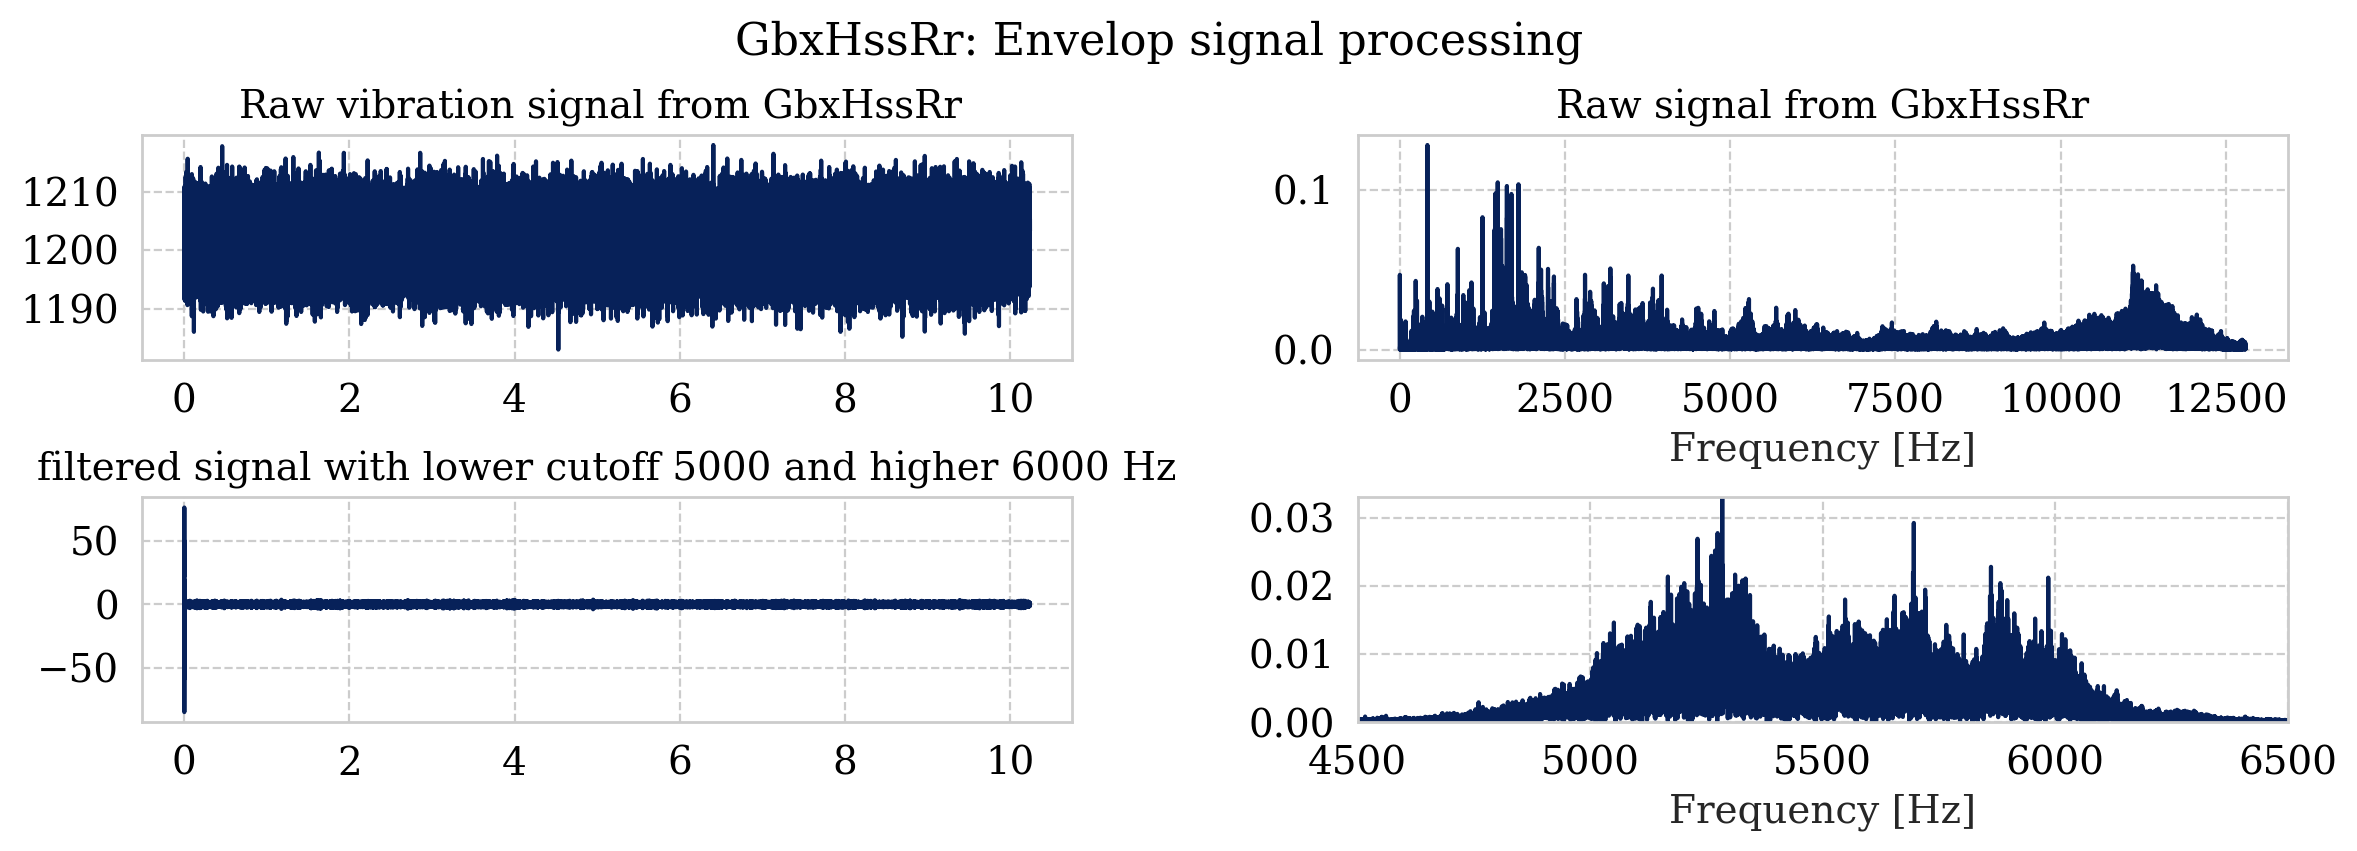

In [124]:
lowcut = 5000
highcut = 6000
fs = fs # already defined
bandpass2_filtered = butter_bandpass_filter(vib_signal_wt4[0],lowcut, highcut, fs, order=5)
bandpass2_filtered
plot_enveloping_process(2,2,COMPONENT_NAME, vib_signal_wt4[0],bandpass2_filtered,times_wt4[0],lowcut,highcut,times_wt4[0] )


### Last interval

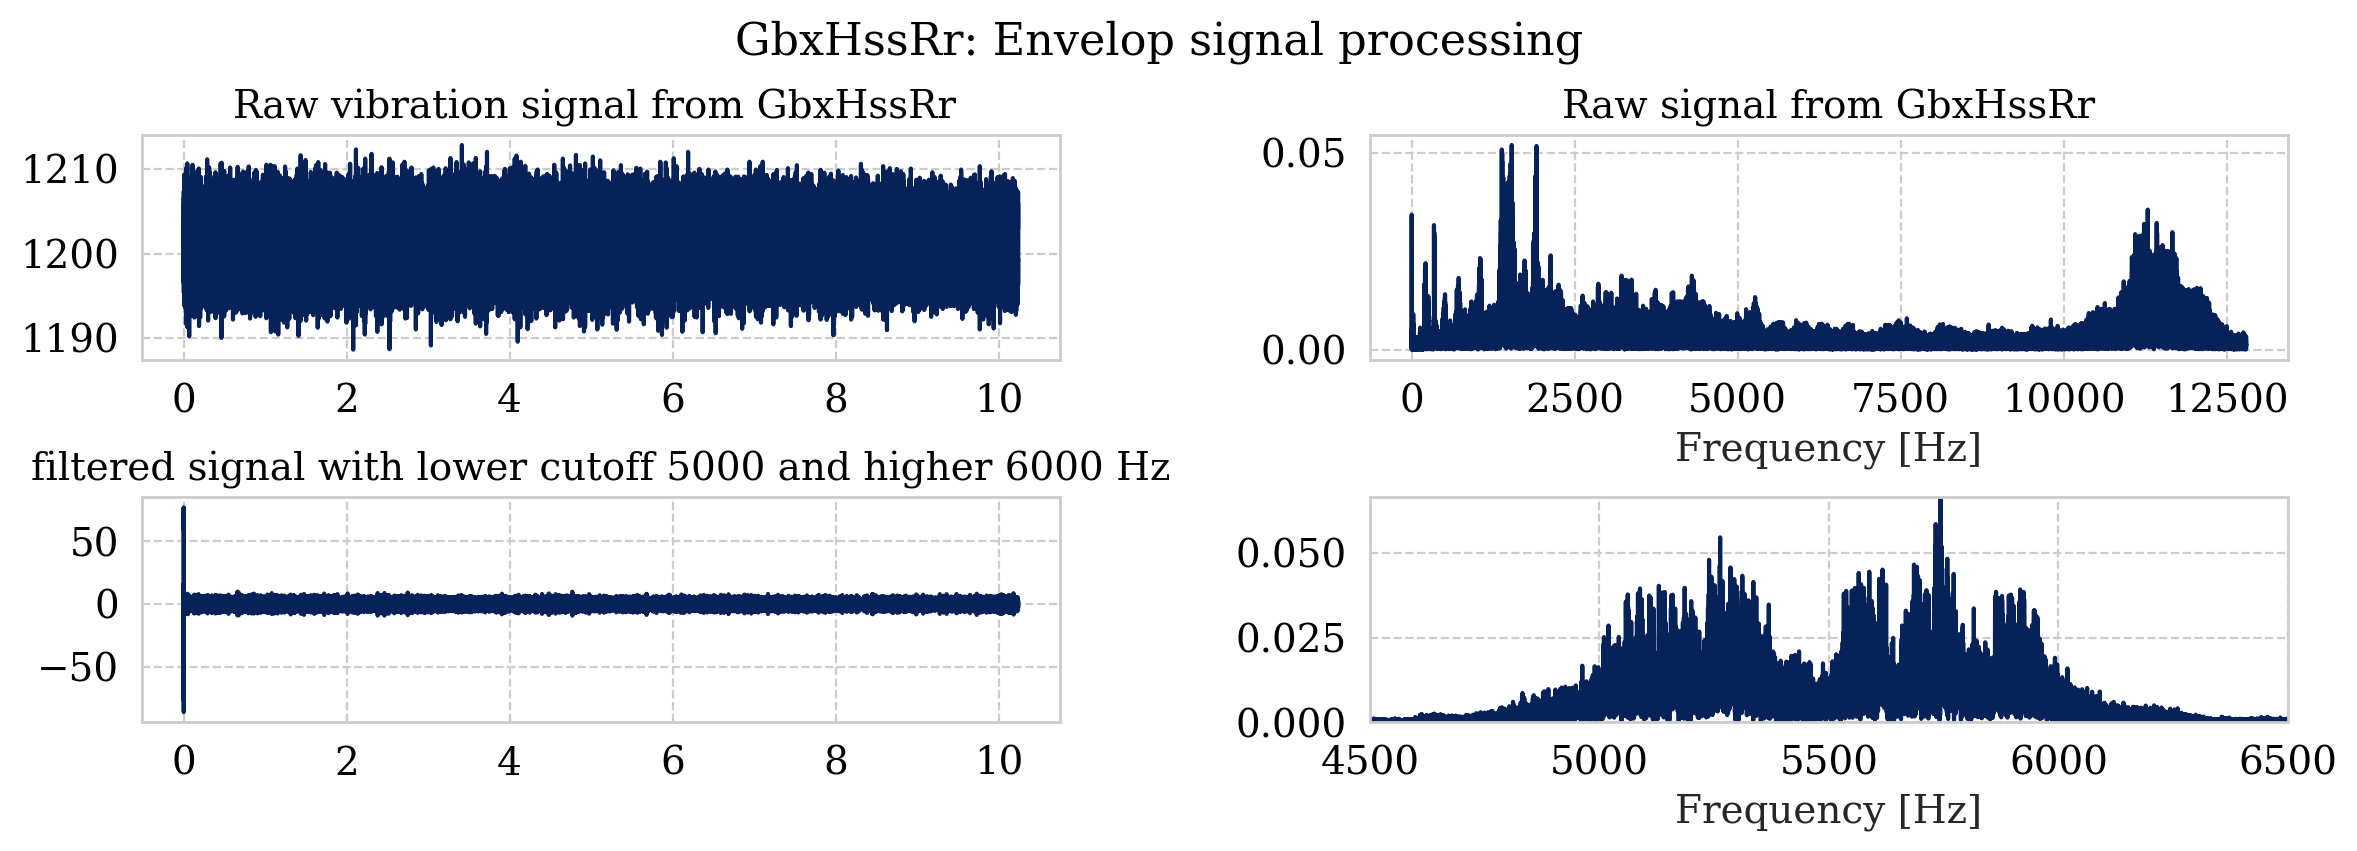

In [134]:
lowcut = 5000
highcut = 6000
fs = fs # already defined
bandpass2_filtered = butter_bandpass_filter(vib_signal_wt4[1],lowcut, highcut, fs, order=5)
bandpass2_filtered
plot_enveloping_process(2,2,COMPONENT_NAME, vib_signal_wt4[-1],bandpass2_filtered,times_wt4[-1],lowcut,highcut)

### Second to last interval

In [139]:
stl_index = len(times_wt4) - 2 # Second to last
print(vib_signal_wt4.shape)
lowcut = 5000
highcut = 6000
fs = fs # already defined
bandpass2_filtered = butter_bandpass_filter(vib_signal_wt4[stl_index],lowcut, highcut, fs, order=5)
bandpass2_filtered
plot_enveloping_process(2,2,COMPONENT_NAME, vib_signal_wt4[stl_index],bandpass2_filtered,times_wt4[stl_index],lowcut,highcut)

(6, 262144)


IndexError: index 8 is out of bounds for axis 0 with size 6

                  0      timestamp
count  2.621440e+05  262144.000000
mean   3.842986e-07       5.119980
std    2.175676e+00       2.956039
min   -8.606025e+01       0.000000
25%   -1.401085e+00       2.559990
50%   -1.854271e-03       5.119980
75%    1.399672e+00       7.679971
max    7.693999e+01      10.239961
                   0      timestamp
count  262144.000000  262144.000000
mean     1201.229925       5.119980
std         2.631820       2.956039
min      1188.623765       0.000000
25%      1199.448529       2.559990
50%      1201.225730       5.119980
75%      1203.002930       7.679971
max      1212.858312      10.239961


,0,timestamp
0,1202.962539,0.000000
1,1201.387293,0.000039
2,1203.083712,0.000078
3,1199.165793,0.000117
4,1199.367748,0.000156
5,1199.973611,0.000195
6,1200.579475,0.000234
7,1200.175566,0.000273
8,1201.266120,0.000313
9,1201.387293,0.000352


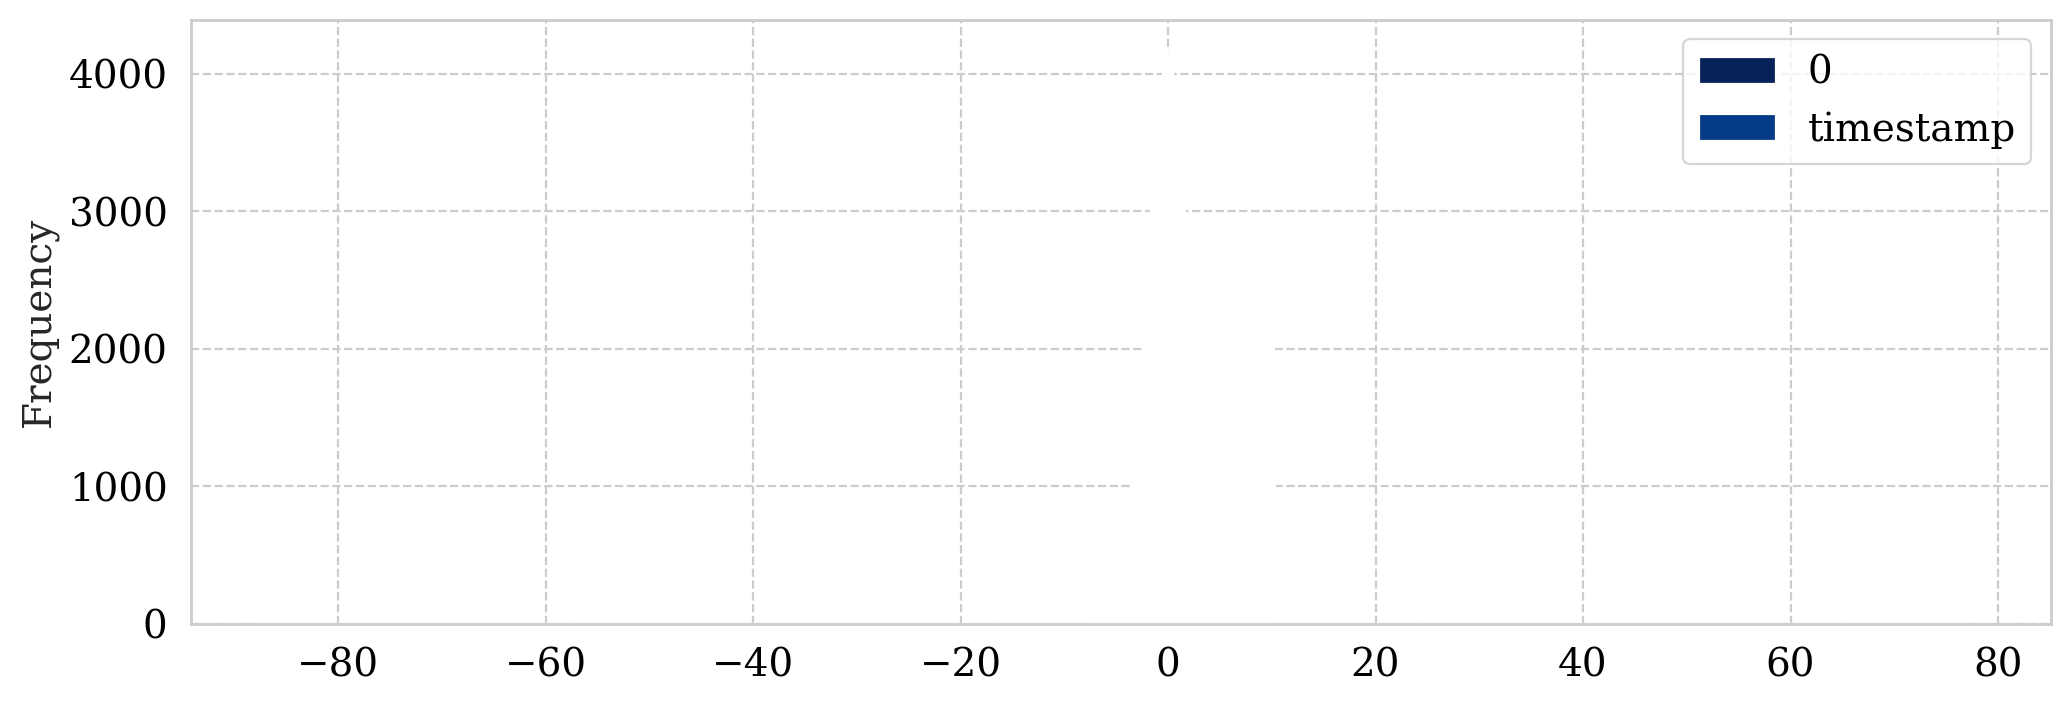

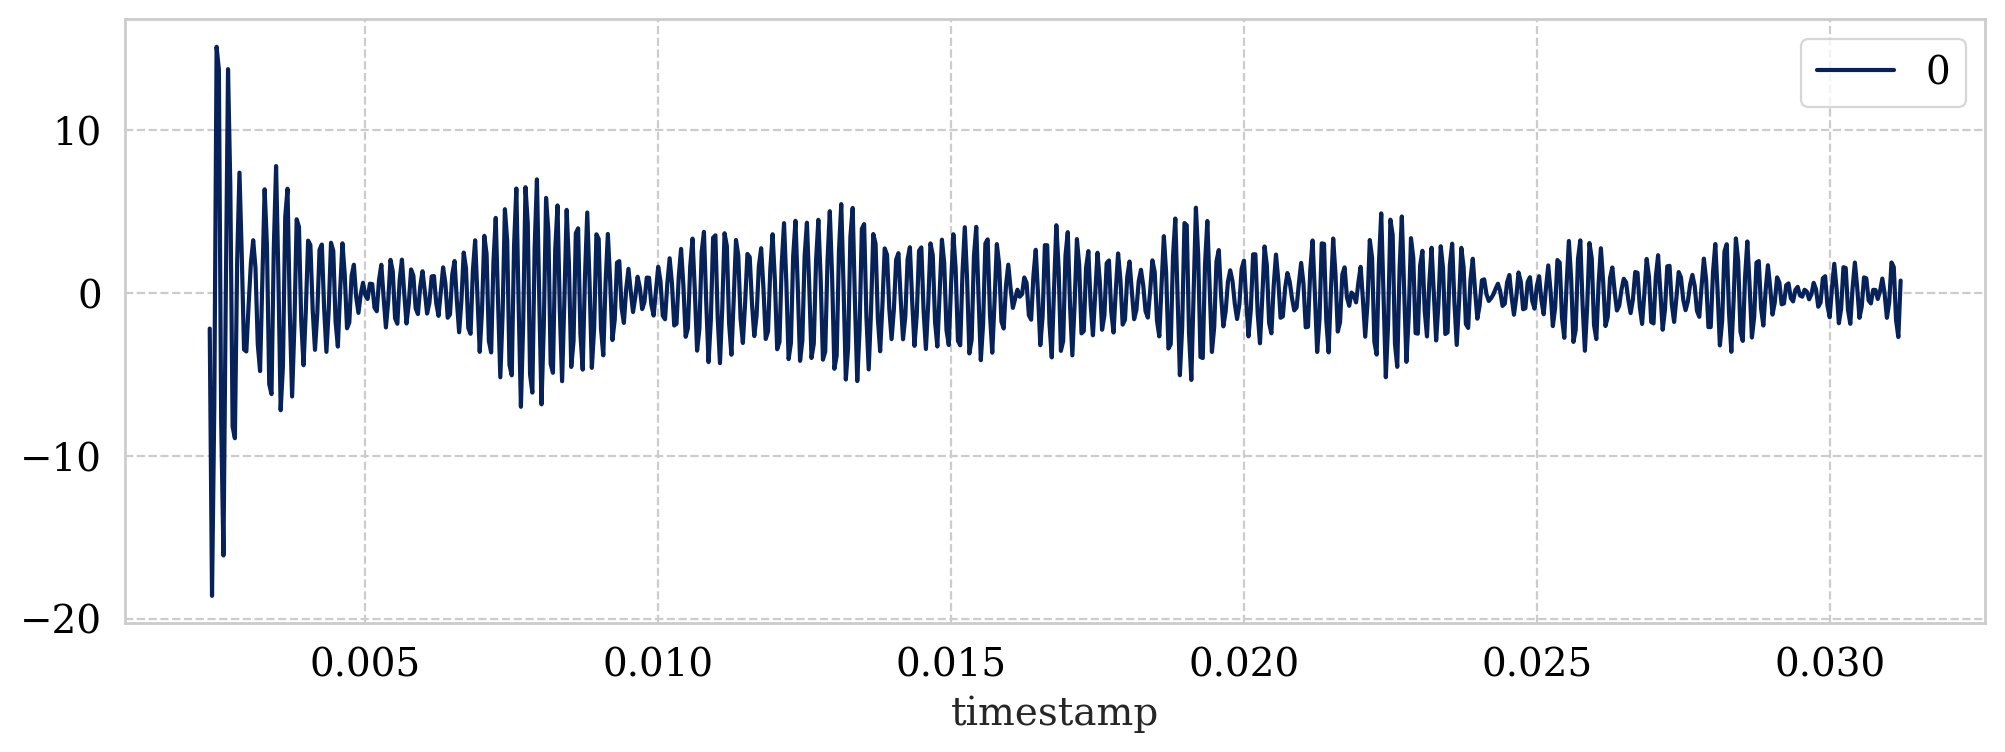

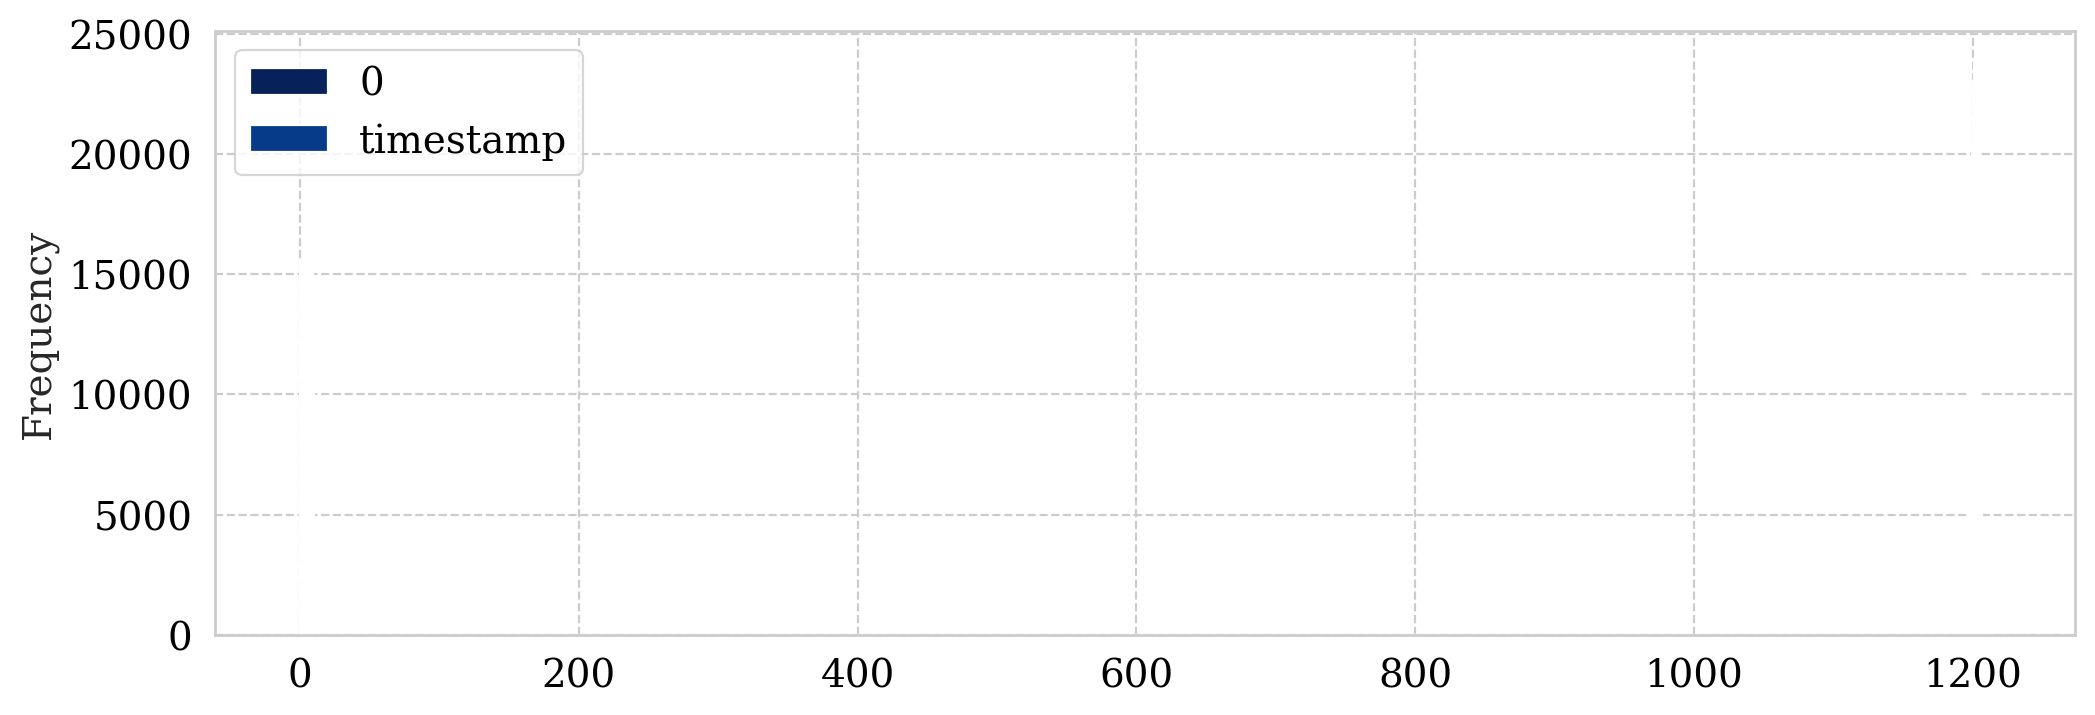

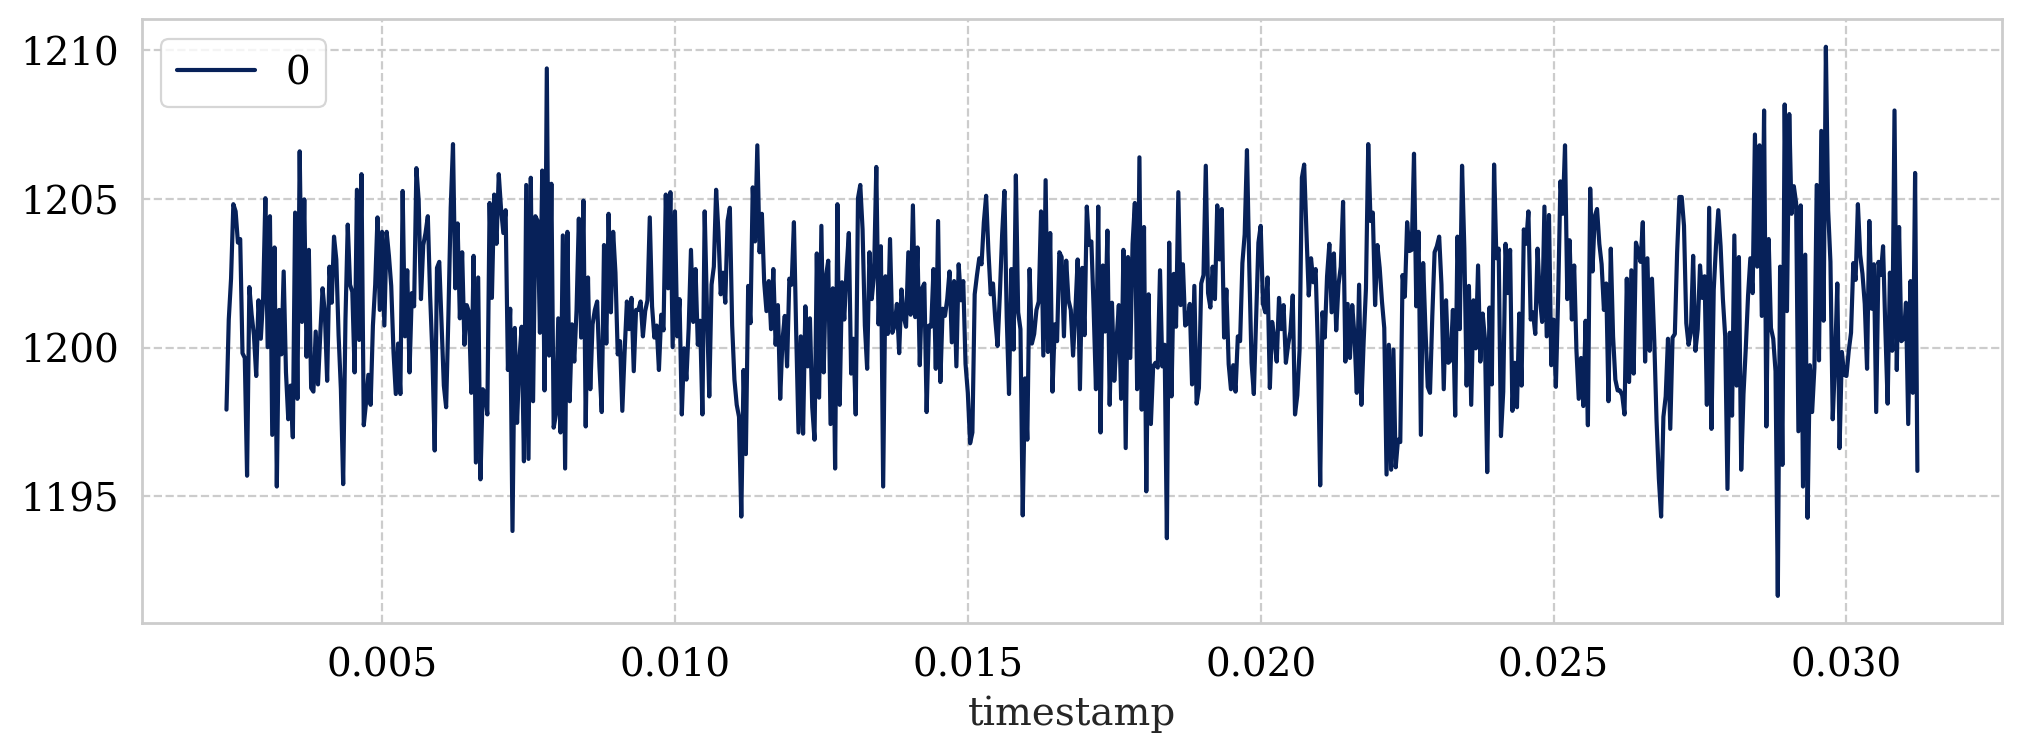

In [126]:
import pandas as pd

df = pd.DataFrame(bandpass2_filtered)
df['timestamp'] = times_wt4[-1]
print(df.describe())
df.plot.hist(bins=2000)
df.iloc[60:800].plot.line(x='timestamp',y=0)
df.head(20)

import pandas as pd

df = pd.DataFrame(vib_signal_wt4[-1])
df['timestamp'] = times_wt4[-1]
print(df.describe())
df.plot.hist(bins=2000)
df.iloc[60:800].plot.line(x='timestamp',y=0)
df.head(20)

                   0
count  262144.000000
mean       -0.000005
std         1.128102
min      -169.656502
25%        -0.514215
50%        -0.000780
75%         0.513342
max       175.627470


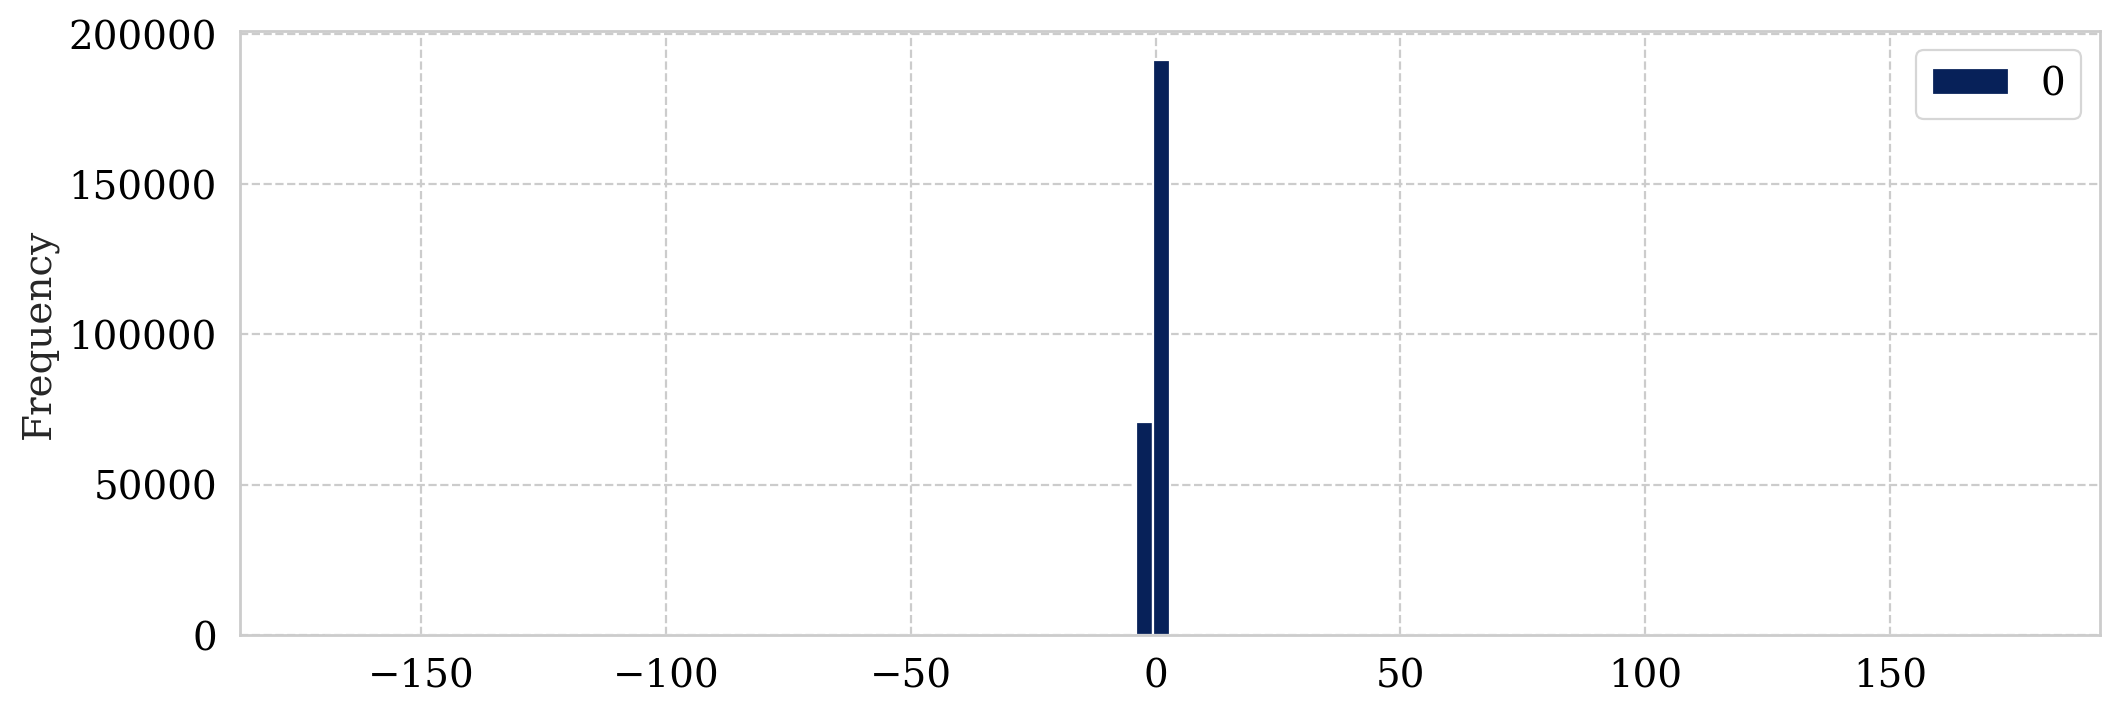

In [127]:
import pandas as pd
df = pd.DataFrame(bandpass1_filtered)
print(df.describe())
df.plot.hist(bins=100)

In [132]:
def plot_enveloping_process(rows, cols, COMPONENT_NAME, raw_signal, filtred_signal, timestamps, lowcut, highcut):
    filtred_signal
    fig, ax = plt.subplots(rows, cols)
    fig.suptitle(f'{COMPONENT_NAME}: Envelop signal processing ',fontsize=16, y=1.05)

    ax[0,0].plot(timestamps,raw_signal)
    ax[0,0].set_title(f"Raw vibration signal from {COMPONENT_NAME} ")
    perform_fft(raw_signal,timestamps,ax[0,1])
    ax[0,1].set_xlabel("Frequency [Hz]")
    ax[0,1].set_title(f"Raw signal from {COMPONENT_NAME}")

    ax[1,0].plot(timestamps,filtred_signal)
    ax[1,0].set_title(f'filtered signal with lower cutoff {lowcut} and higher {highcut} Hz')
    perform_fft(filtred_signal, timestamps, ax[1,1])
    ax[1,1].set_xlabel("Frequency [Hz]")
    ax[1,1].set_xlim(lowcut-500,highcut+500)
    plt.tight_layout()
    plt.margins(0)

In [ ]:
fig, ax = plt.subplots(2, 2)
fig.suptitle(f'{COMPONENT_NAME}: Envelop signal processing ',fontsize=16, y=1.05)

ax[0,0].plot(range(len(vib_signal_wt4[0])),vib_signal_wt4[0])
ax[0,0].set_title(f"Raw vibration signal from {COMPONENT_NAME} ")
perform_fft(vib_signal_wt4[0],times_wt4[0],ax[0,1])
ax[0,1].set_xlabel("Frequency [Hz]")
ax[0,1].set_title(f"Raw signal from {COMPONENT_NAME}")


ax[1,0].plot(range(len(filtered_sine_wt4)),filtered_sine_wt4)
ax[1,0].set_title(f'filtered signal with lower cutoff {hp_cutoff} Hz')
perform_fft(filtered_sine_wt4, times_wt4[0],ax[1,1])
ax[1,1].set_xlabel("Frequency [Hz]")
plt.tight_layout()
plt.margins(0)

In [ ]:
perform_fft(vib_signal_wt4[0], times_wt4)
# perform_fft(filtered_sine_wt4, times_wt4)

In [ ]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t) + np.sin(2*np.pi*300*t)++ np.sin(2*np.pi*425*t)
fig, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz, 20 Hz, 300 Hz and 425 sinusoids')
ax1.axis([0, 1, -2, 2])



## Another type of filter

In [ ]:
def hp_filter(amplitudes, lower_freq_limit):
    sig = amplitudes
    fig, (ax2) = plt.subplots(1, 1, sharex=True)
    sos = signal.butter(10, lower_freq_limit, 'hp', fs=1000, output='sos')
    filtered = signal.sosfilt(sos, sig)
    ax2.plot(t, filtered)
    ax2.set_title(f'After {lower_freq_limit} Hz high-pass filter')
    ax2.axis([0, 1, -2, 2])
    ax2.set_xlabel('Time [seconds]')
v    plt.show()
    perform_fft(filtered, t)

def lp_filter(amplitudes, upper_freq_limit):
    sig = amplitudes
    fig, (ax2) = plt.subplots(1, 1, sharex=True)
    sos = signal.butter(10, upper_freq_limit, 'lp', fs=1000, output='sos')
    filtered = signal.sosfilt(sos, sig)
    ax2.plot(t, filtered)
    ax2.set_title(f'After {upper_freq_limit} Hz high-pass filter')
    ax2.axis([0, 1, -2, 2])
    ax2.set_xlabel('Time [seconds]')
    plt.tight_layout()
    plt.show()
    perform_fft(filtered, t)

hp_filter(sig,250)
lp_filter(sig,50)


In [ ]:
sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
